# Large Data Analytics 
## Part 1: Ordinary Least Squares

This is Part 1 of ipython notebook that illustrates 'Large Data Analytics' based on a the material from a course taught by *Todd Munson* and *Stefan Wild*.  The concrete examples in this notebook use energy data for the University of Chicago buildings.

## Sections
- [Introduction](#intro)
- [What is ordinary least square (OLS)](#ols-intro)
- [Dataset](#dataset)
- [Import data into ipython notebook](#import-data)
- [Pick building and term to work on](#building)
- [Calculating OLS using IPython](#ols)
    - [Example 1: Effect of Temperature on Energy Use](#ols)
        - [Basic Algorithm](#basic)
        - [First Algorithm for small variables](#first)
        - [Second Algorithm for small variables](#second)
        - [Comparison with inbuilt methods](#section)
    
    
-----------------

<a id='intro'></a>

## Introduction

Data is being collected at an astonishing rate by corporations to determine, for example, customer preferences in order to target advertising.  Scientific experiments and simulations also generate vast amounts of data to be analyzed to make discoveries, such as confirmation of the Higgs boson from experimental data collected by the Large Hadron Collider.

#### Where does data come from?
- Companies like Google and Netflix
- Large data sets associated with network traffic
- Scientific experiments like fluid flow simulations
- Measured data from sensors and experiments 

**In this illustration: we will use electricity meter data from University of Chicago buildings**

#### What do analysts do with the data?
- Marketing, making recommendations
- Estimating human behavior and finding anomalies
- System state estimation
- Inverse problems

#### What techniques do analysis apply?
- Feature extraction and machine learning
- Regression models and classification
- Data assimilation

#### Why is big data hard?
- Real data is messy
- Online updates to the data
- Need to tradeoff complexity and data access
- Few complete passes through the data allowed
- Sometimes access each piece of data only once
- May not be able look at some data at all

------------------------

<a id = "ols-intro"></a>

## What is regression and ordinary least squares (OLS)?

Regression is a technique for explaining the relationship between parameters (inputs) and observations (outputs).  One example is to determine the relationship between temperature and humidity (inputs) and energy usage (output) based on recorded historical data contains measurements of the temperature, humidity, and energy usage.  If the regression is good, then we can then use the discerned relationship to predict the energy usage today based on the current temperature and humidity.

Ordinary least squares is a regression method that posits a linear relationship between the inputs and outputs.  Often, the data is not perfectly represented by a linear relationship and we calculate the best linear relationship by minimizing the sum of the squared errors between the linear model and the observations.  Hence, the name least squares.

The sum of squared errors is not always appropriate and we may use different measures, such as the worst error.  When the data is not well represented by a linear relationship, nonlinear models can be applied.  In either case, regression method changes and we would no longer be using ordinary least squares.

For this notebook, we will restrict our regression methods to ordinary least squares.

-----------------------

<a id="dataset"></a>

## Dataset

In 2015, the 160 University of Chicago campus buildings and grounds used $40 million worth of energy. Analyzing the data trends will help improve our understanding of campus energy usage and increase energy efficiency!

Dataset consists of the following:

- Campus electricity data for 7 buildings (294 meters) from 2014 to 2016, at 15 minute intervals.

- Weather station data for the same time interval from Regenstein Weather Station


--------------------

<a id="import-data"></a>

## Import data into ipython notebook

#### Import python libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

#### Read Files

In [2]:
df_meter = pd.read_csv('uc_comed_data_cond.csv', header = 'infer')

In [3]:
df_weather = pd.read_csv('weather_prepared_final.csv')

####  Converting date-time

In [4]:
df_meter['DATETIME'] = pd.to_datetime(df_meter['DATETIME'])
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])

------------------

<a id='building'></a>

## Pick building and term to work on

#### Function to choose data based on term, building_name, and weather_station

In [5]:
def get_data(term, building_name):
    ## PICK USAGE DATA BASED ON TERM AND BUILDING_NAME
    usage = df_meter[(df_meter['TERM'] == term) & (df_meter['DISCRIPT1'] == building_name)]
    
    ## GET START AND END DATE OF THE TERM
    start_date = usage.iloc[0]['DATETIME']
    end_date = usage.iloc[-1]['DATETIME']

    
    df_bool1 = (df_weather['DATE'] == start_date)
    index1 = df_bool1[df_bool1 == True].index.tolist()[0]
    
    df_bool2 = (df_weather['DATE'] == end_date)
    index2 = df_bool2[df_bool2 == True].index.tolist()[0]
    
    try: 
        temp = df_weather.loc[index1:index2+1] 
    except:
        temp = df_weather.loc[index1:end]
    
    usage_temp = pd.merge(left = usage, right = temp, left_on='DATETIME', right_on = 'DATE', how='left')
    return(usage_temp)

##### values for term, building_name, weather_station below

In [6]:
terms = df_meter.TERM.unique()
terms

array(['Winter 2014', nan, 'Spring 2014', 'Summer 2014', 'Autumn 2014',
       'Winter 2015', 'Spring 2015', 'Summer 2015', 'Autumn 2015',
       'Winter 2016'], dtype=object)

In [7]:
building_names = df_meter.DISCRIPT1.unique()
building_names

array(['Bernard Mitchell Hospitial', 'John Crerar Library',
       'Steam Plant Power Plant', 'Chapin Hall',
       'Social Science Research Building',
       'Duchossois Center for Advanced Medicine', 'Harris School'], dtype=object)

#### Select TERM, BUILDING_NAME & Get Dataframe

In [8]:
usage_temp = get_data('Summer 2015', 'Harris School')

##### plot of Energy use vs time, Temperature vs time & Humidity vs time

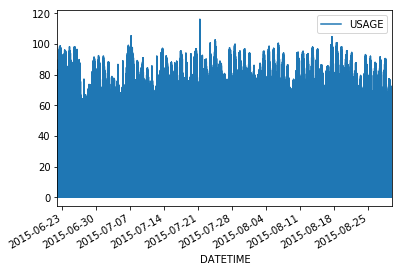

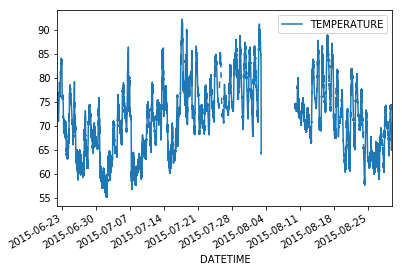

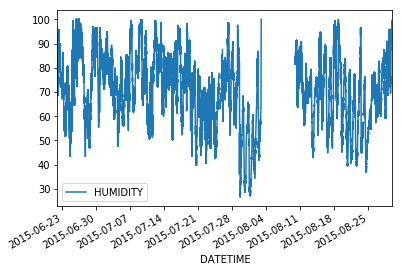

In [9]:
usage_temp.plot(x = 'DATETIME', y = 'USAGE')
usage_temp.plot(x = 'DATETIME', y = 'TEMPERATURE')
usage_temp.plot(x = 'DATETIME', y = 'HUMIDITY')

----------------

<a id='ols'></a>

Using university electricity data, we would like to find how temperature and humidity affects energy use. 

### Terminology 

In this example, temperature and humidity are **parameters** that we want to relate to our **observation**, energy use.  Our **linear model** describes how the parameters might be related to the observation.  This model consists of **coefficients**, which are multiplicative factors for prarameters.

***Model: coefficient x parameter = model_observation*** 

We choose the coefficients to make the **model_observation** as close to the real observation as possible by minimizing the sum of the squared errors.  This is achieved by appropriately varying the coefficient values. The best  set of coefficient values will have the least distance between between the model_observation and real observation as measured by the Euclidean norm.

Note we add a constant parameter to the matrix so that we can shift the data and improve the relation computed.

### Data Representation

- **A is matrix with first column the constant one, second column temperature, and third column humidity** 
    - Number of columns = 3 (constant, temperature, and humidity)
    - Each row of temperature and humidity corresponds to a particular time
    - There are as many entries as the number of time steps
    - Number of rows = number of time steps
        
- **b is a column of energy use**
    - Number of columns = 1 (energy use)
    - Each row corresponds to a particular time, that matches with the times in A matrix
        - Eg., If the first row in A matrix corresponds to 00:30 AM on 2016-1-1, the first row in b also corresponds to the same time
    - Number of rows = number of time steps
    
- **x is matrix of coefficients, and Model is A*x **
    - [recap matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication)
    - x has 3 rows corresponding to the three columns in A
    - x has only 1 column
        
- **y is the error **
    - the difference between the prediction (Ax) and the observation (b), \\(y = Ax - b\\)
    - y has 1 column and as many rows as the number of time steps
    
Mathematically, Ordinary Least Square (OLS) amounts to minimizing the sum of the squared errors:

\\(0.5 \parallel y \parallel_2^2  =  0.5 \sum_i y_i^2 \\)

After substituting the definition of the errors, we obtain the convex, quadratic optimization problem

\\(\underset{x}{\min} 0.5 \parallel Ax − b \parallel^2 \\)


# Calculating Ordinary Least Square using IPython:
## Example 1: Effect of weather on energy use

### Step 1: Cleaning the data

As mentioned earlier, real data can be messy. In our example, if we look at the plots of temperature vs time and humdity vs time, we see that for some chunk of dates, we have no observations. We will start by dropping those dates from our calculations.


In [10]:
usage_temp = usage_temp.dropna(subset = ['TEMPERATURE', 'HUMIDITY'])
## droppin NaN values

### Step 2: Creating the A matrix (column of property: temperature, humidity)

In [11]:
A1 = np.array(usage_temp['TEMPERATURE'])
## first column: temperature
A2 = np.array(usage_temp['HUMIDITY'])
## second column: humidity
A = np.column_stack((np.ones(len(A1)),A1,A2))
## combine two columns to get A matrix

A

array([[  1. ,  75.9,  76.4],
       [  1. ,  76.8,  72.5],
       [  1. ,  75.6,  77.1],
       ..., 
       [  1. ,  66.4,  94. ],
       [  1. ,  66.7,  98.2],
       [  1. ,  66.6,  96.3]])

### Step 3: Creating column vector b (column of observation: energy use)

In [12]:
b = np.array(usage_temp['USAGE'])
b

array([  4.14,   4.14,   4.32, ...,  61.56,  61.56,  61.56])

<a id = "basic"></a>

## The basic algorithm

The definition of the two norm and some algebra allows us to write the least-squares minimization problem as an equivalent optimization problem with a convex quadratic objective function

\\(\underset{x}{\min} 0.5 x^T A^T A x - x^T A^T b + 0.5 b^T \\) 

Because the optimization problem is convex, the first-order optimality conditions are both necessary and sufficient for x to be a solution.  These conditions in the unconstrained optimization problem above are that the gradient of the objective function with respect to x is equal to zero

\\( A^T A x - A^T b = 0 \\)

Solving this linear system of equations for x gives the closed form solution

\\( x = (A^T A)^{-1} A^T b \\)

We note that the standard errors use the diagonal of \\( (A^T A)^{−1} \\).  The calculation of the diagonal of this matrix can be performed in a reasonable amount of time only when we have a small numbers of columns.

The steps to the basic algorithm are
  - Compute \\( B = A^T A \\) using \\(O(mn^2) \\) operations
  - Compute \\( B^{-1} \\) using \\(O(n^3)\\) operations
  - Multiply \\( x = B^{-1} A^T b \\) using \\(O(n^3+mn)\\) operations

### Step 4: Calculating x and standard errors using basic algorithm

In [18]:
## Calculate A^T
Aprime = A.conj().T

## Calculate B = A^T A
B = Aprime.dot(A)
## Calculate B^{-1}
Binv = la.inv(B)
## Solve the system 
x = Binv.dot(Aprime.dot(b)) 
x

array([-7.52913375,  0.54639255,  0.0187545 ])

In [14]:
stderrs = np.diag(Binv)
stderrs

array([  4.96652742e-03,   5.48611408e-07,   1.34629220e-07])

<a id = "first"></a>

## Improved algorithm

The basic algorithm explicitly computes the inverse of \\( A^T A \\).  The typical method for computing this inverse is Gaussian elimination, which is not numerically stable in general.  The improved algorithm replaces using the inverse by solving the system of equations

\\( Bx = A^T b \\)

The computation of the standard errors matrix remains unchanged.

### Step 5: Calculating x and using improved algorithm

In [17]:
Aprime = A.conj().T
B = Aprime.dot(A)
x = la.solve(B, Aprime.dot(b))
x

array([-7.52913375,  0.54639255,  0.0187545 ])

In [16]:
stderrs = np.diag(la.inv(B))
stderrs

array([  4.96652742e-03,   5.48611408e-07,   1.34629220e-07])

<a id = "second"></a>

## Algorithm using factorization

The improved algorithm hides the linear algebra behind the solve operation.  We can decide how the solve is performed by factoring the \\( B \\) matrix using a Cholesky factorization where \\( B = L L^T \\) where \\(L\\) is a lower triangular matrix.  The Cholesky factorization is numerically stable and we then need to solve the system of equations

\\( L L^T x = A^T b \\)

where the solves exploit the fact that \\( L \\) is a triangular matrix.

The steps are
  - Compute \\( B = A^T A \\)
  - Perform Cholesky factorization of \\( B \\)
  - Compute \\( x = L^{-T} (L^{-1} (A^T b)) \\)

Note: the numpy linalg package does not have wrappers for triangular matrices, so this implementation will not be as efficient as using the scipy.linalg.solve_triangular() function.

### Step 6: Calculating x and standard errors using factorization

In [19]:
L = la.cholesky(B)
Lprime = L.conj().T
L

array([[   216.85017869,      0.        ,      0.        ],
       [ 15545.22860109,   1588.30603465,      0.        ],
       [ 15342.15752103,  -1688.84872302,   2725.40052666]])

In [23]:
x = la.solve(Lprime, la.solve(L, Aprime.dot(b)))
x

array([-7.52913375,  0.54639255,  0.0187545 ])

### Plotting

Plotting the original data with the regression model can demonstrate to our eyes the quality of the regression.  For high dimensional problems, we can only look at part of the data.


In [30]:
usage_temp['fit'] = np.ones(len(A1))*x[0]+np.array(usage_temp['TEMPERATURE'])*x[1]+np.array(usage_temp['HUMIDITY'])*x[2]

(0, 100)

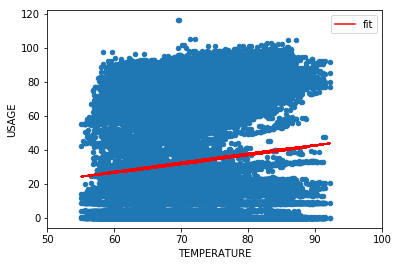

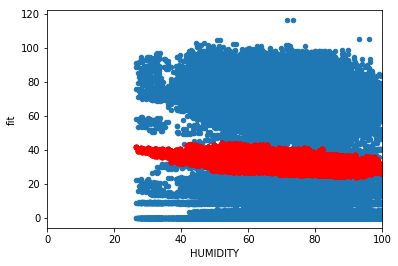

In [43]:
ax = usage_temp.plot(x='TEMPERATURE', y='USAGE',kind='scatter')
usage_temp.plot(x='TEMPERATURE', y = 'fit', kind='line', ax=ax, color='red')
ax.set_xlim([50,100])

ax2 = usage_temp.plot(x='HUMIDITY', y='USAGE',kind='scatter')
usage_temp.plot(x='HUMIDITY', y = 'fit', kind='line', ax=ax2, color='red')
ax2.set_xlim([0,100])

<a id= "compare"></a>

## Comparison with inbuilt methods

Python programming language also has inbuilt functions to calculate ordinary least squares.  The numerical method employed behind the scenes is described above.  This inbuild function also computes statistics regarding the regression.  These statistics provide quantitative information on the quality of the regression.


In [27]:
import statsmodels.formula.api as sm
model = sm.ols(formula='USAGE ~ TEMPERATURE + HUMIDITY', data=usage_temp)
result = model.fit()
result.params

Intercept     -7.529134
TEMPERATURE    0.546393
HUMIDITY       0.018754
dtype: float64

------------------------

------------------------

## Work in progress....

### Todd's notes
Basic Algorithm

- Assuming A has full column rank

\\(x = (A^T A)^{-1} A^T b\\)

where \\(A^T A \in R^{n×n}\\) is symmetric

- Standard errors use \\(diag((A^T A)^{−1})\\)   
- Two cases
  - Number of variables is small
  - Number of variables is large -- we will ignore large
  
##### Matlab

x = (A' \* A) \\(A’ \* b);

stderrs = diag(inv(A’ \* A));

### Todd's notes
Generalized Least Squares

##### Matlab code

Give the previosly defined A and b,

B = A’ \* (Sigma \\A);

L = chol(B);

x = L \\(L’ \\(A’ * (Sigma \\b)));


In [21]:
Sigma = np.corrcoef(A1, A2)
Sigma

array([[ 1.        , -0.53512818],
       [-0.53512818,  1.        ]])

In [22]:
B = Aprime.dot(la.lstsq(Sigma, A))

LinAlgError: Incompatible dimensions